## Pneumonia Detection using Transfer learning_VGG16

## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Load the Dataset

In [2]:
# Directories for the dataset
train_dir = 'D:/shivani/archive (4)/chest_xray/train'
test_dir = 'D:/shivani/archive (4)/chest_xray/test'

# Data generators with augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

## Prepare the Data and Split the Data and 

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Build the Random Forest Model

In [4]:
# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layer
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Freeze the convolutional layers to retain pre-trained weights
for layer in vgg.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = Flatten()(vgg.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=x)

In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // test_generator.batch_size,
                    epochs=5)

Epoch 1/5
163/163 [==============================] - 2450s 15s/step - loss: 0.2106 - accuracy: 0.9094 - val_loss: 0.1929 - val_accuracy: 0.9326
Epoch 2/5
163/163 [==============================] - 1711s 10s/step - loss: 0.1742 - accuracy: 0.9319 - val_loss: 0.1516 - val_accuracy: 0.9457
Epoch 3/5
163/163 [==============================] - 1638s 10s/step - loss: 0.1495 - accuracy: 0.9427 - val_loss: 0.2205 - val_accuracy: 0.9260
Epoch 4/5
163/163 [==============================] - 1424s 9s/step - loss: 0.1422 - accuracy: 0.9442 - val_loss: 0.1459 - val_accuracy: 0.9424
Epoch 5/5
163/163 [==============================] - 1472s 9s/step - loss: 0.1285 - accuracy: 0.9471 - val_loss: 0.1378 - val_accuracy: 0.9474


## Evaluate the Model 

In [25]:
# Evaluate the model on the test set
test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
y_pred = np.round(preds).astype(int)
y_true = test_generator.classes

19/19 [==============================] - 209s 11s/step


In [31]:
y_true_new = y_true[0:608]
len(y_true_new)

608

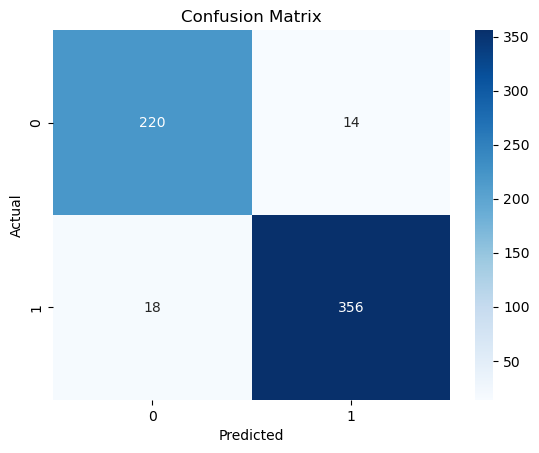

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true_new, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
# Classification report
print(classification_report(y_true_new, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93       234
   Pneumonia       0.96      0.95      0.96       374

    accuracy                           0.95       608
   macro avg       0.94      0.95      0.94       608
weighted avg       0.95      0.95      0.95       608



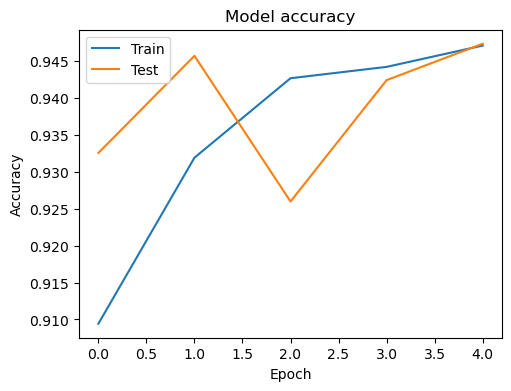

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

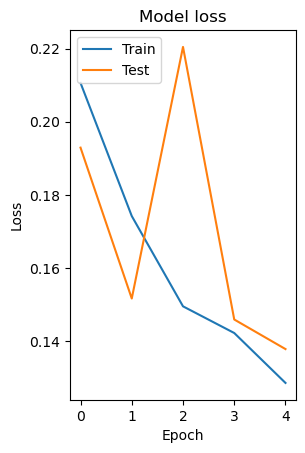

In [13]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()